In [1]:
import itertools
import random
import numpy 
import json
import matplotlib.pyplot as plt
import os
import pandas as pd
from pathlib import Path 
import sys
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
## Read all datasets for every hole size, splitted by starting year, and plot them
YEARS = [str(year) for year in range(1990,2019)]
collaborations_df = pd.read_csv('myDATA/00-collaboration_df_with_starting_years.csv')
min_size = 1
max_size = 28

In [3]:
def get_tot_auths_num():
    file = 'myDATA/00-collaboration_df_with_starting_years.csv'
    collaborations_df = pd.read_csv(file)
    num_auths_by_y = []
    num_new_auths_by_y = []
    YEARS = [str(year) for year in range(1990,2019)]  
    tot_auth = 0
    for i in range(len(YEARS)):
        y = YEARS[i]
        
        # number of new authors in the given year
        num_new_auths_by_y.append(len(collaborations_df.loc[collaborations_df["start_year"] == int(y)]))
        
        # total number of new authors in the given year
        tot_auth += num_new_auths_by_y[i]                         
        num_auths_by_y.append(tot_auth)
    return num_auths_by_y

# return a vector containig the total number of collaboration for each year
def get_tot_collabs_num():
    file = 'myDATA/00-collaboration_df_with_starting_years.csv'
    collaborations_df = pd.read_csv(file)
    num_colls_by_y = []
    YEARS = [str(year) for year in range(1990,2019)]  
    tot_auth = 0
    for i in range(len(YEARS)):
        y = YEARS[i]
        # total number of collaborations in the given year
        num_colls_by_y.append(collaborations_df[y].sum())
    return num_colls_by_y

In [4]:
def get_f_by_auth(df):
    x=[]
    y=[]
    j=0
    tot_auths = get_tot_auths_num()
    for i in df:
        if(i!="ID"):
            y.append(df[i].mean())
            x.append(tot_auths[j])
            j+=1
    return x,y

def get_f_by_colls(df):
    
    tot_colls = get_tot_collabs_num()
    x=[]
    y=[]
    for i in df:
        if(i!="ID"):
            y.append(df[i].mean())
            j=YEARS.index(str(i))
            x.append(tot_colls[j])
            
    return x,y

In [5]:
# computer error between each fitted curve and real data
def err_calc_polyfit(y, y1):
    err = 0
    for i in range(len(y)):
        err += pow(abs(y[i] - y1[i]), 2)
    return err

def tot_err_polyfit(x_y_fit):
    total_error = 0
    for y in YEARS[:-1]:
        err = err_calc_polyfit(x_y_fit[y]["y"], x_y_fit[y]["fit_y"])
        total_error += err
    return str(total_error)

# compute error for the general function 
def err_calc(y, y1):
    err = 0
    for i in range(len(y)):
        err += pow(abs(y[i] - y1[i]), 2)
    return err

def tot_err(gamma, beta):
    total_error = 0
    for y in YEARS[:-1]:
        err = err_calc(x_y_fit[y]["y"],best_g(x_y_fit[y]["x"], gamma, beta))
        total_error += err
    return str(total_error)

def func1(t, tv, gamma, beta):
    return (1+gamma)* pow((t/tv), beta) - gamma

def best_g(xdata, gamma, beta):
    y = []
    for x in xdata:
        y.append(func1(x, xdata[0], gamma, beta))
    return y

In [6]:
# find the best values for gamma and beta
import scipy.optimize as optimize

def f(params):
    gamma, beta = params
    tot = 0
    for v in YEARS[:-1]:
        t_v = x_y_fit[v]["x"][0]
        for i in range(len(x_y_fit[v]["x"])):
            t_i = x_y_fit[v]["x"][i]
            f = x_y_fit[v]["y"][i]
            tot += pow(abs(f - gamma * pow((t_i/t_v), beta)) - gamma, 2)
    
    return tot

================================================================ HOLE SIZE 1 =================================================================
1990 -> gamma -0.6330775436662227 , beta 0.6733801527670561
1991 -> gamma -0.033129379018743105 , beta 0.6653976252507253
1992 -> gamma 0.399299723687501 , beta 0.6593833989687344
1993 -> gamma 1.507709530300348 , beta 0.6162088539713094
1994 -> gamma 0.1975867051860178 , beta 0.736318765379639
1995 -> gamma 0.2275138936460873 , beta 0.8259570057208867
1996 -> gamma 3.036836255535408 , beta 0.6991525218092545
1997 -> gamma 2.051663980768967 , beta 0.7783710755129342
1998 -> gamma 2.2191802331415316 , beta 0.8247892087744793
1999 -> gamma 1.8501965543538816 , beta 0.8735366481824982
2000 -> gamma 2.8713875970642593 , beta 0.8492227456750439
2001 -> gamma 5.348069155378264 , beta 0.8159154298522959
2002 -> gamma 5.724634609399181 , beta 0.8578466789039523
2003 -> gamma 6.052217510098307 , beta 0.8850896515522167
2004 -> gamma 15.99413248841574 , b

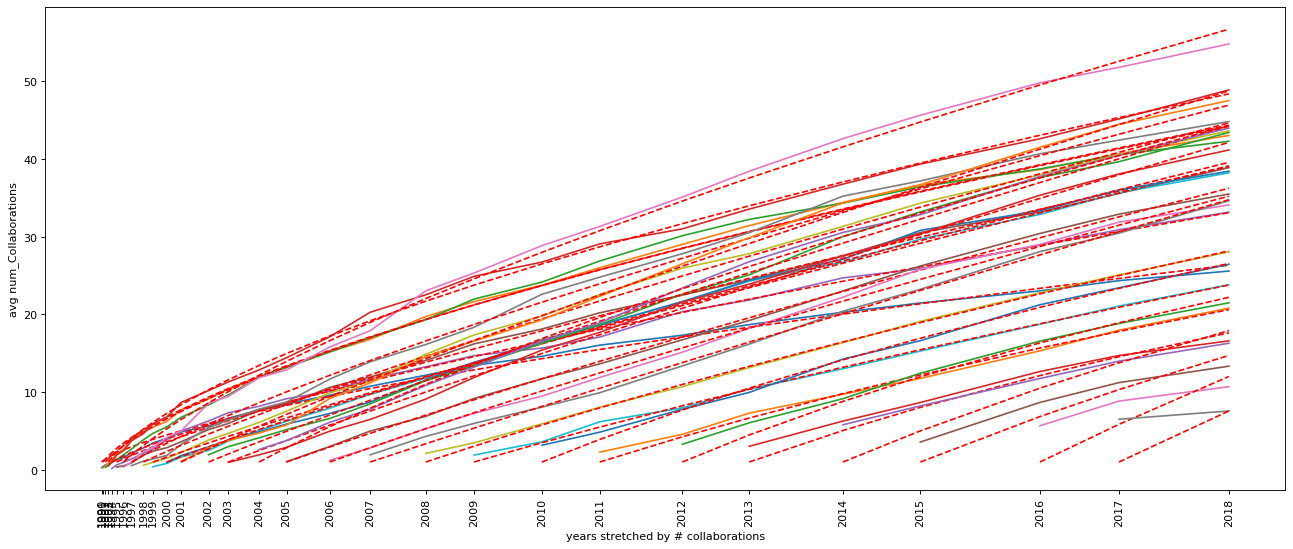

total error for all fitted curves 300.19946197663296
10.325755453389046 0.21467017270138844
============================================================= starting year 1990 =============================================================


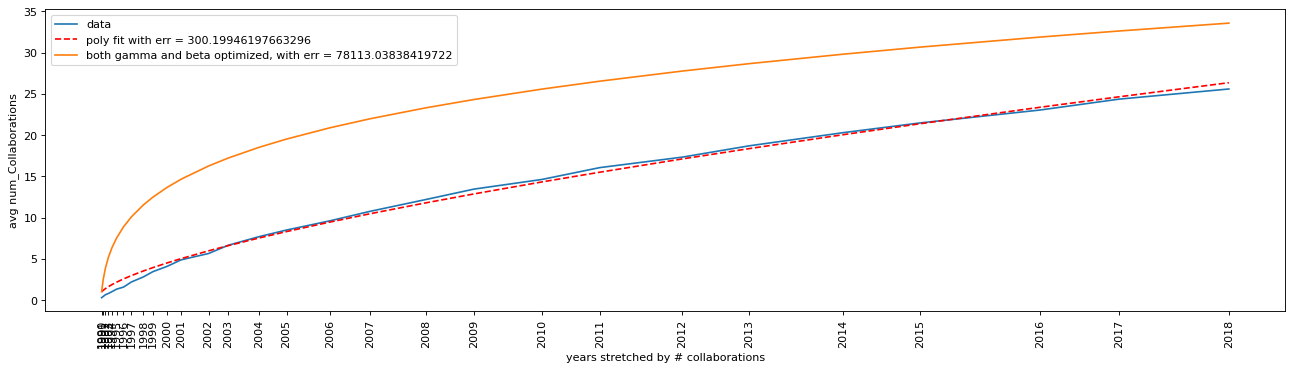

============================================================= starting year 1991 =============================================================


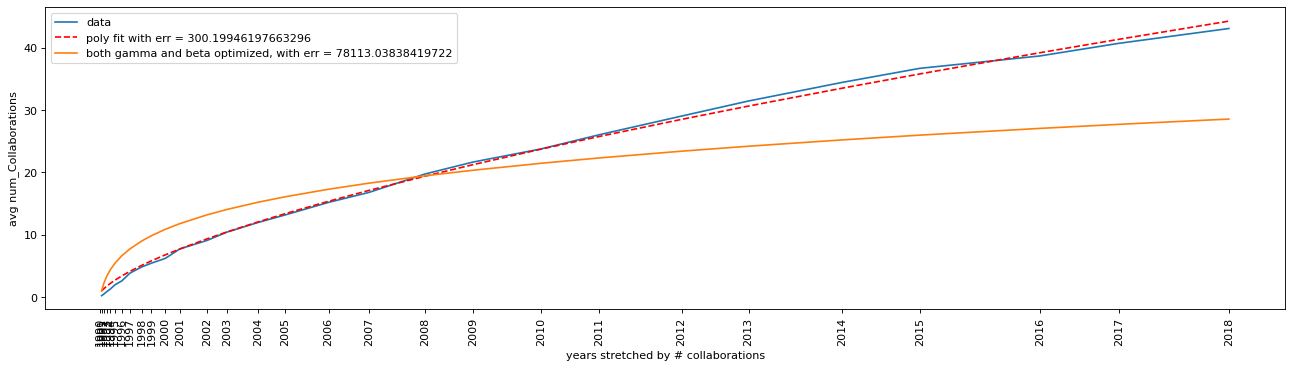

============================================================= starting year 1992 =============================================================


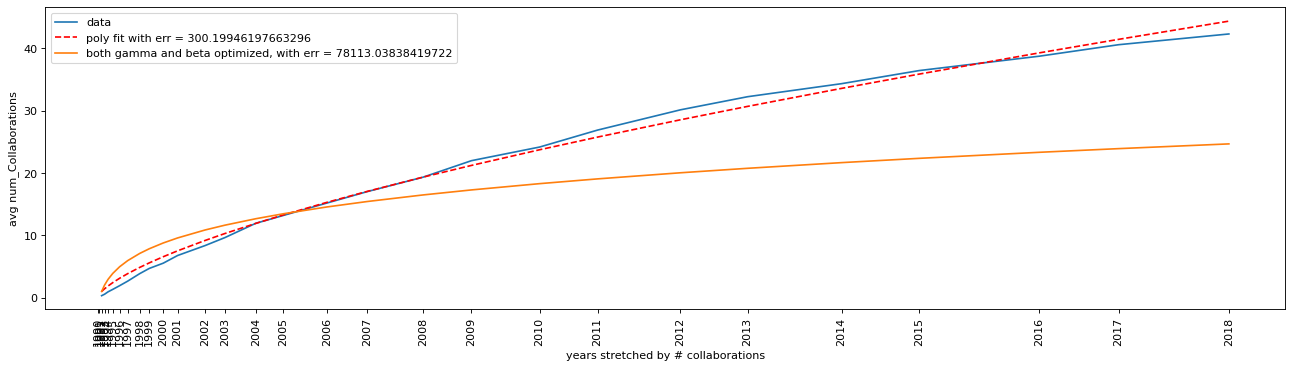

============================================================= starting year 1993 =============================================================


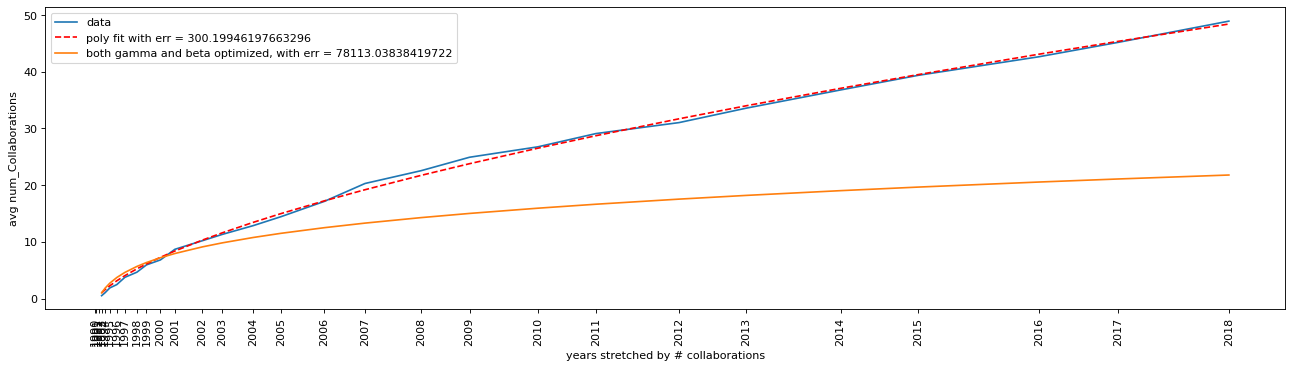

============================================================= starting year 1994 =============================================================


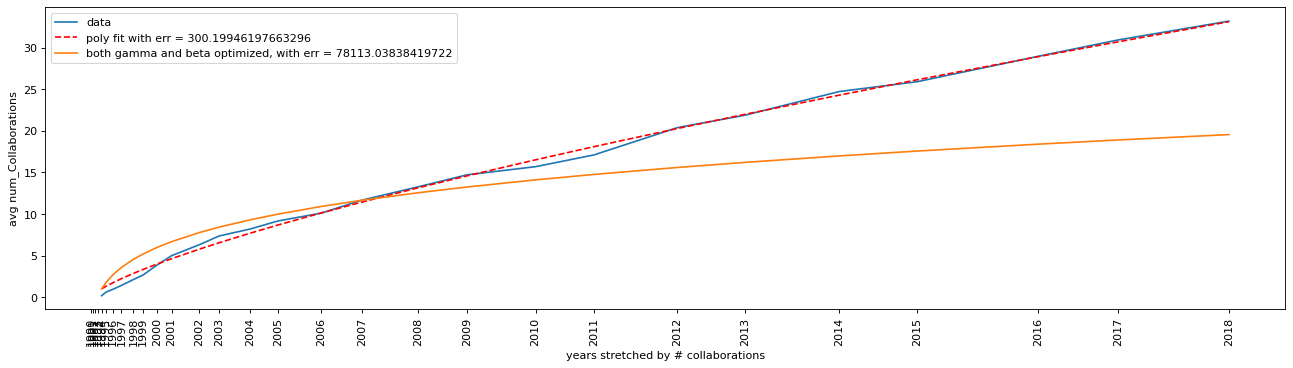

============================================================= starting year 1995 =============================================================


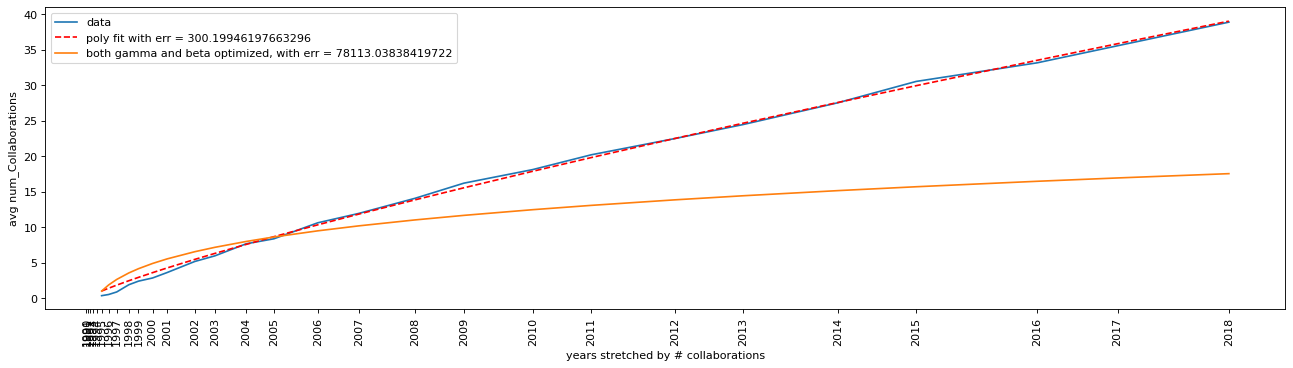

============================================================= starting year 1996 =============================================================


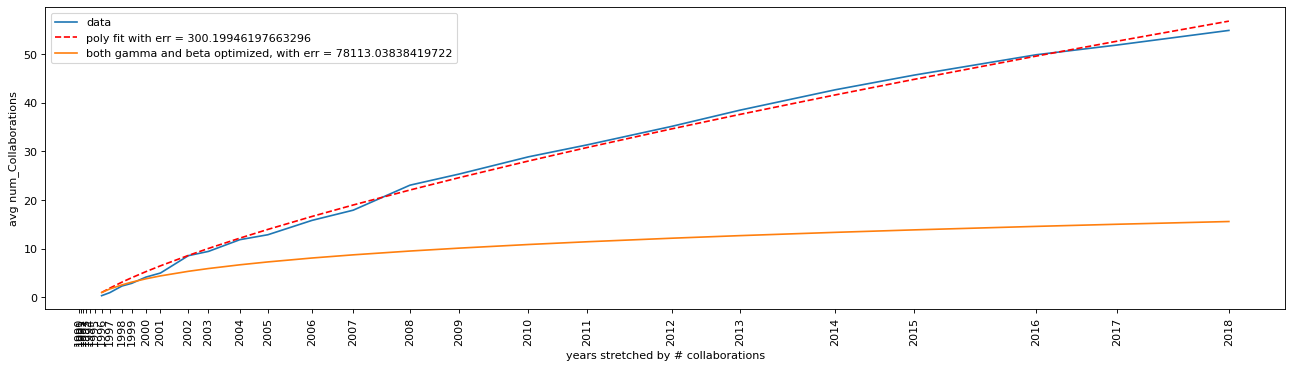

============================================================= starting year 1997 =============================================================


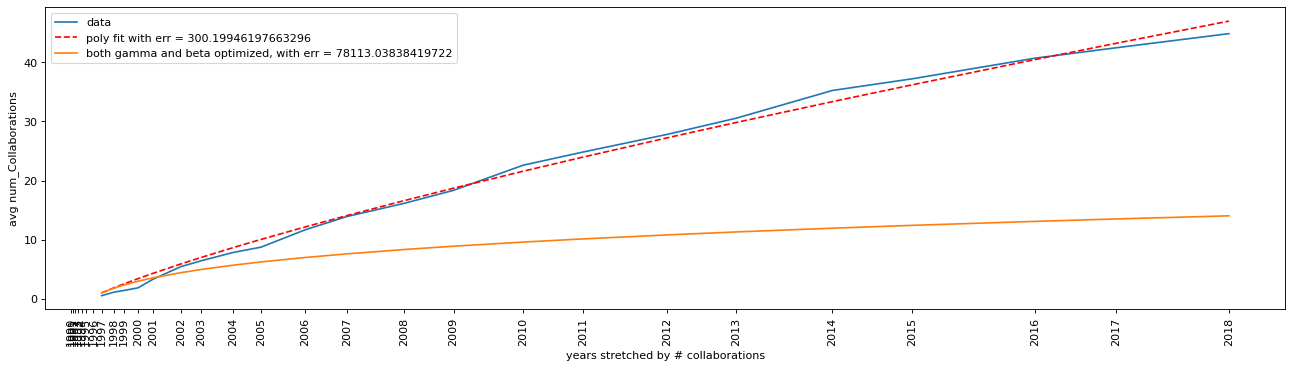

============================================================= starting year 1998 =============================================================


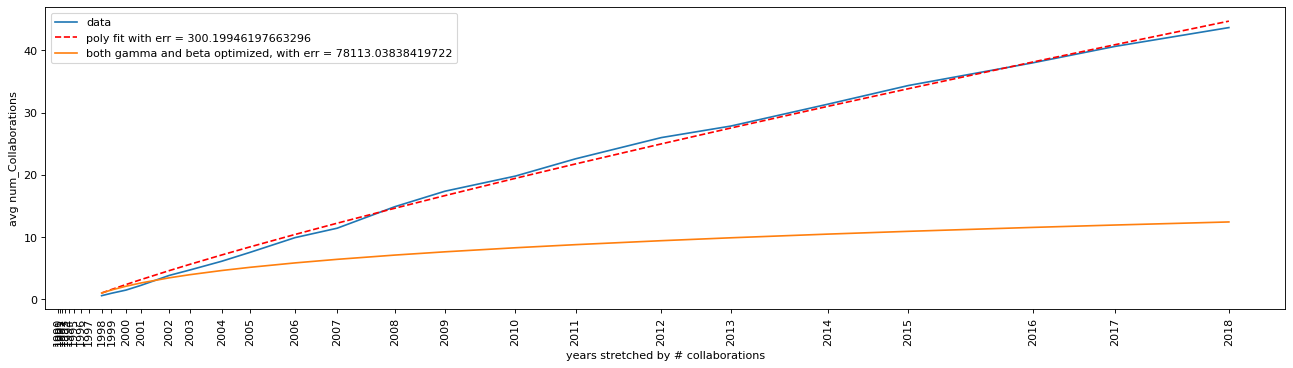

============================================================= starting year 1999 =============================================================


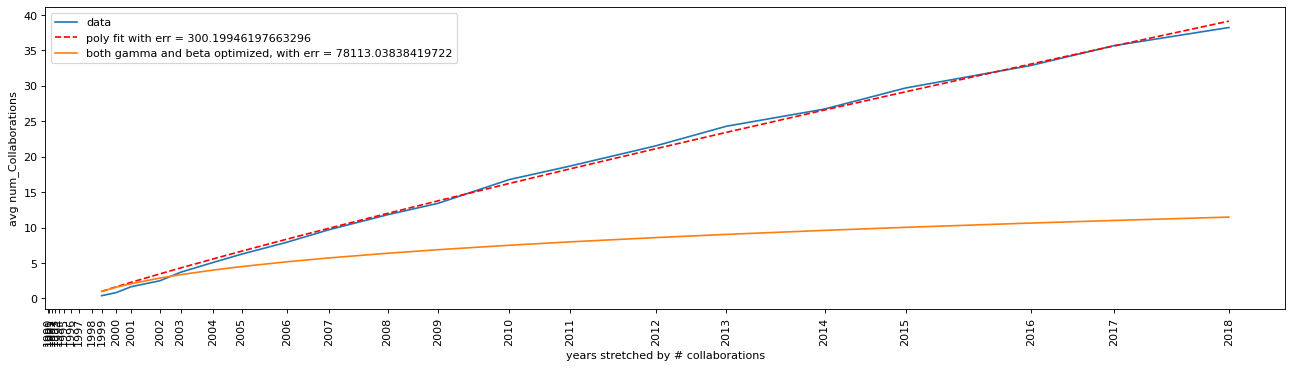

============================================================= starting year 2000 =============================================================


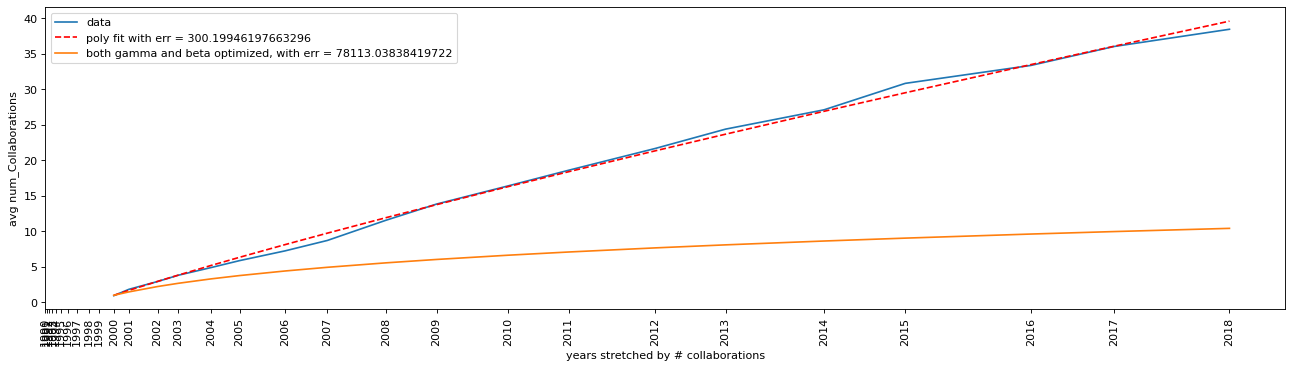

============================================================= starting year 2001 =============================================================


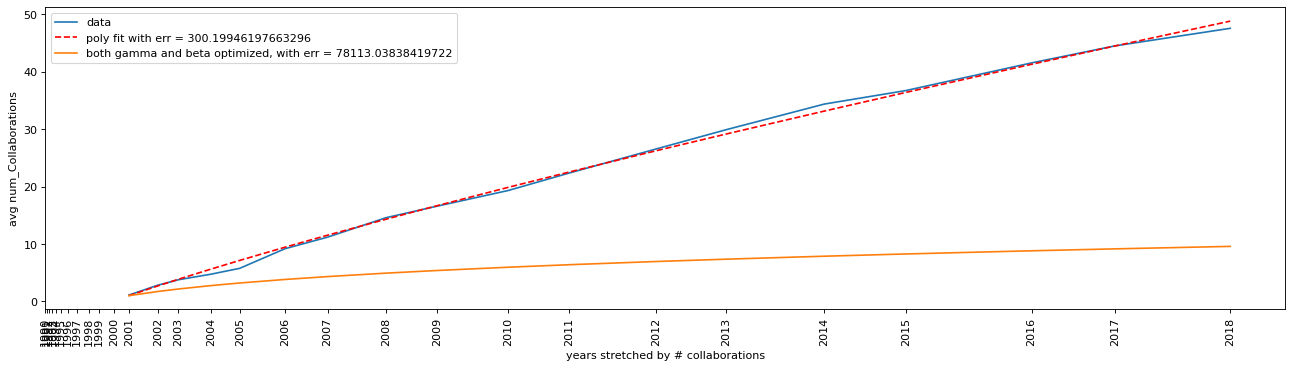

============================================================= starting year 2002 =============================================================


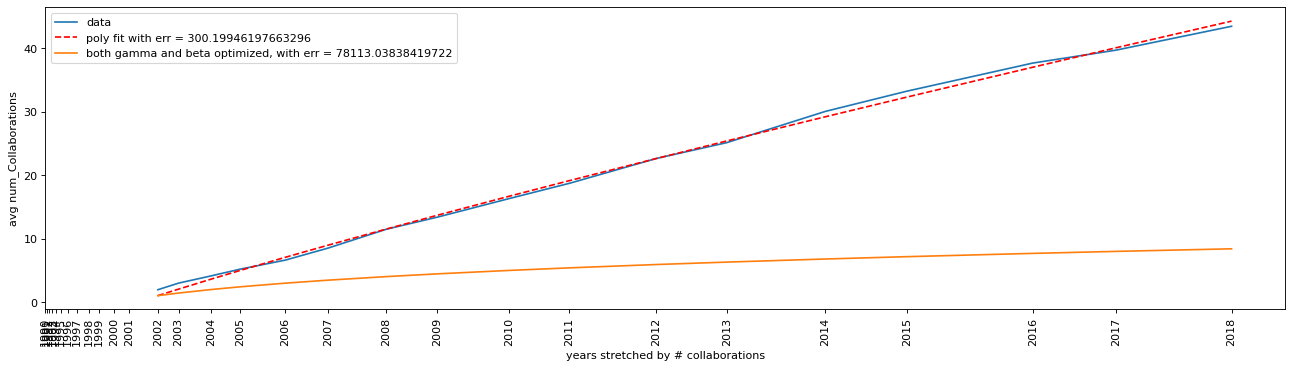

============================================================= starting year 2003 =============================================================


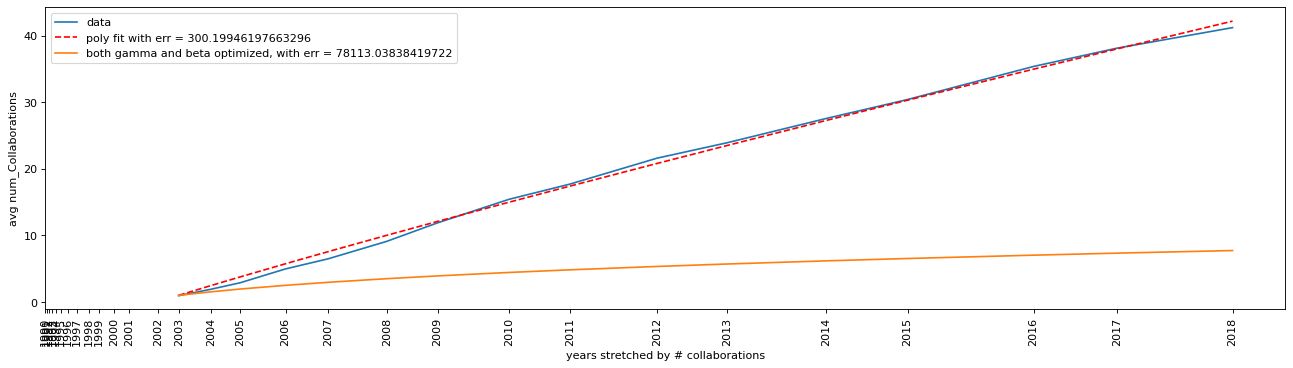

============================================================= starting year 2004 =============================================================


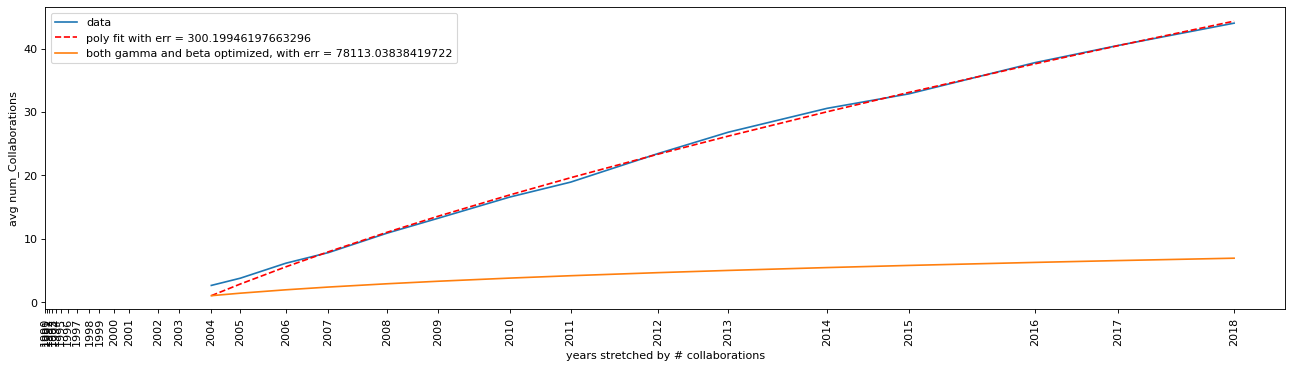

============================================================= starting year 2005 =============================================================


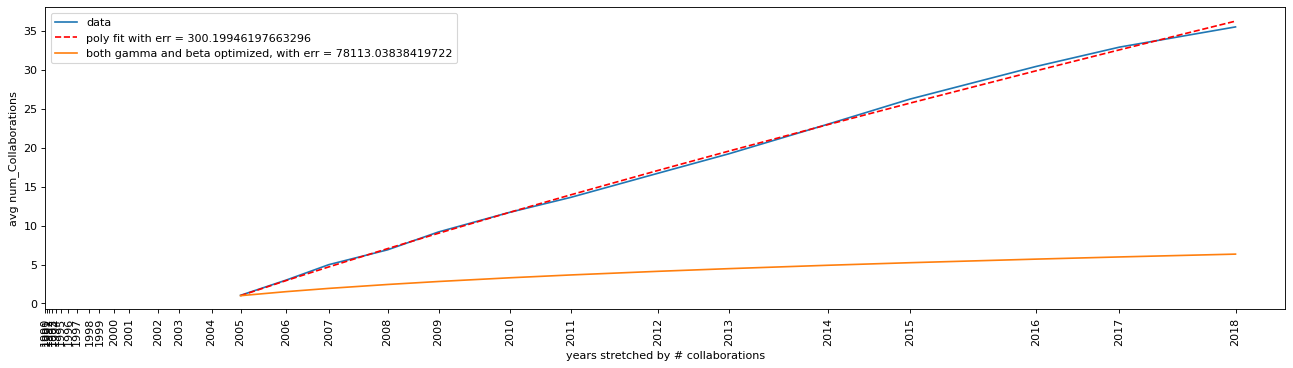

============================================================= starting year 2006 =============================================================


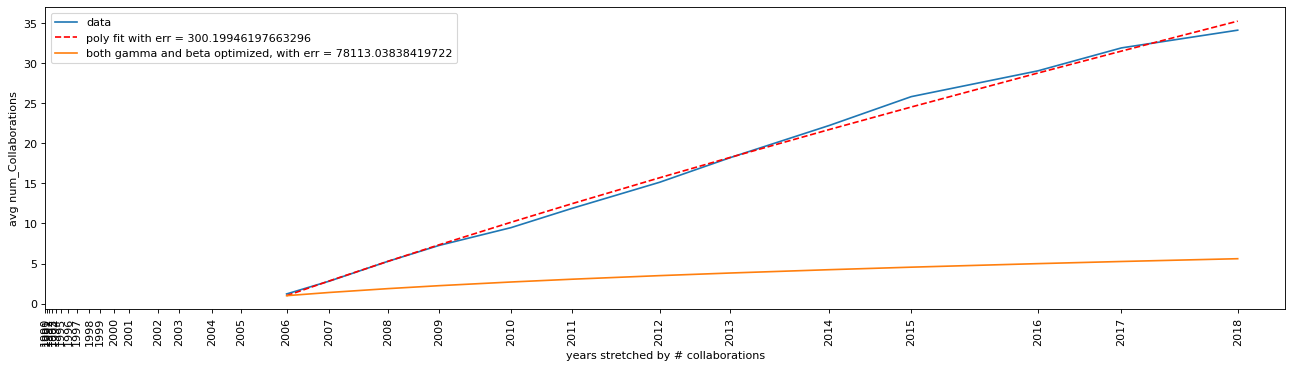

============================================================= starting year 2007 =============================================================


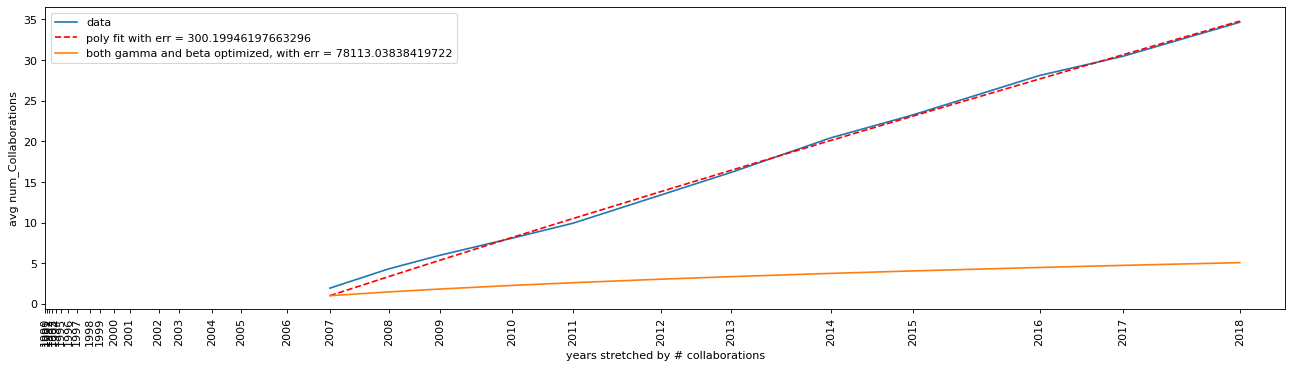

============================================================= starting year 2008 =============================================================


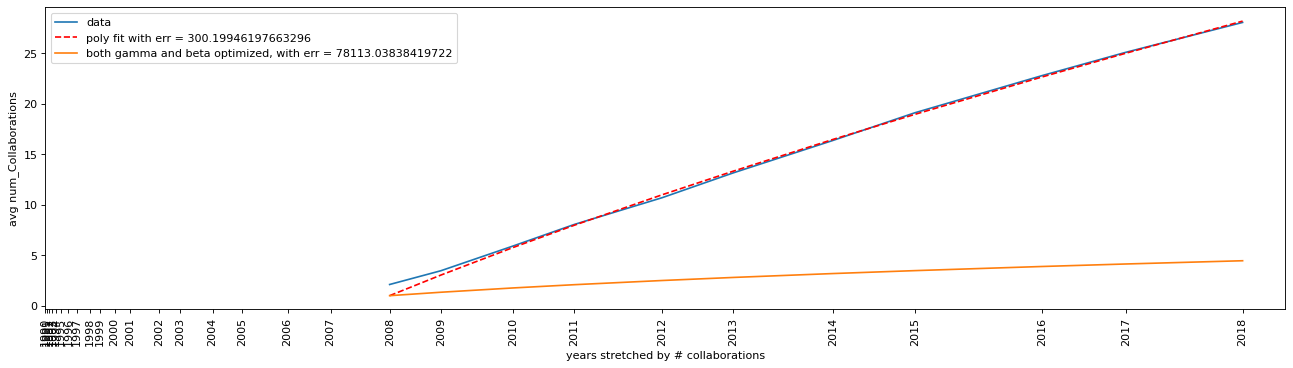

============================================================= starting year 2009 =============================================================


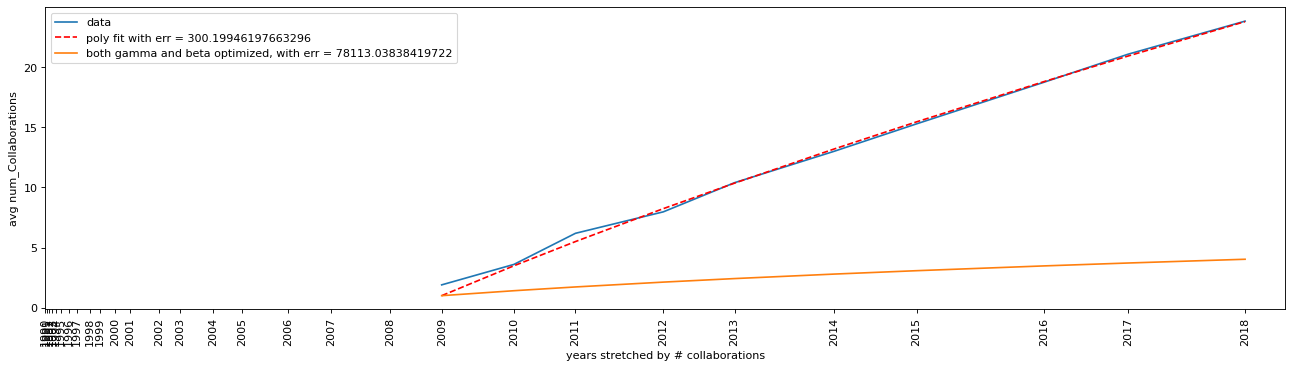

============================================================= starting year 2010 =============================================================


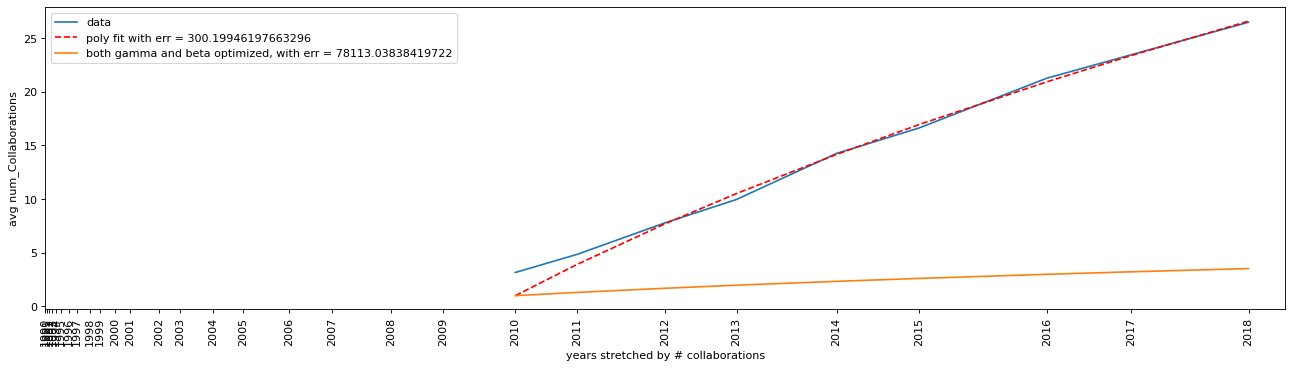

============================================================= starting year 2011 =============================================================


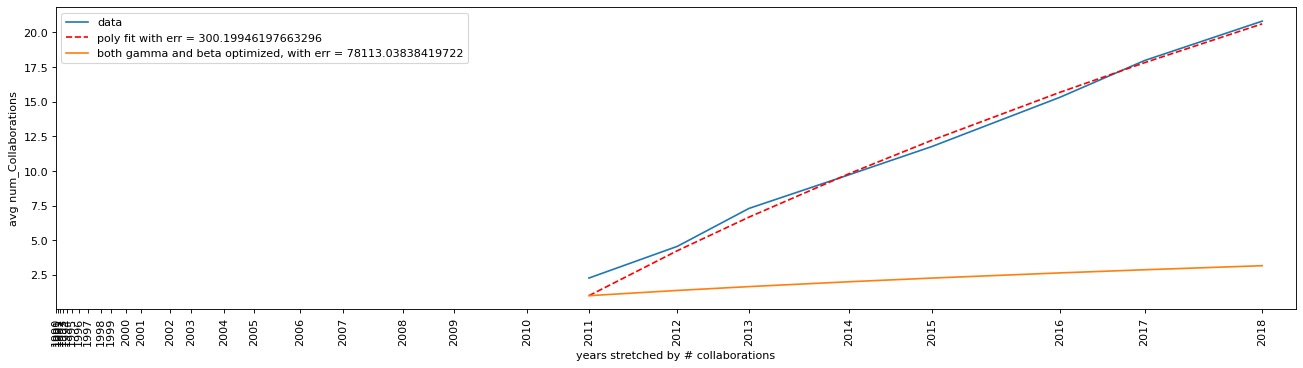

============================================================= starting year 2012 =============================================================


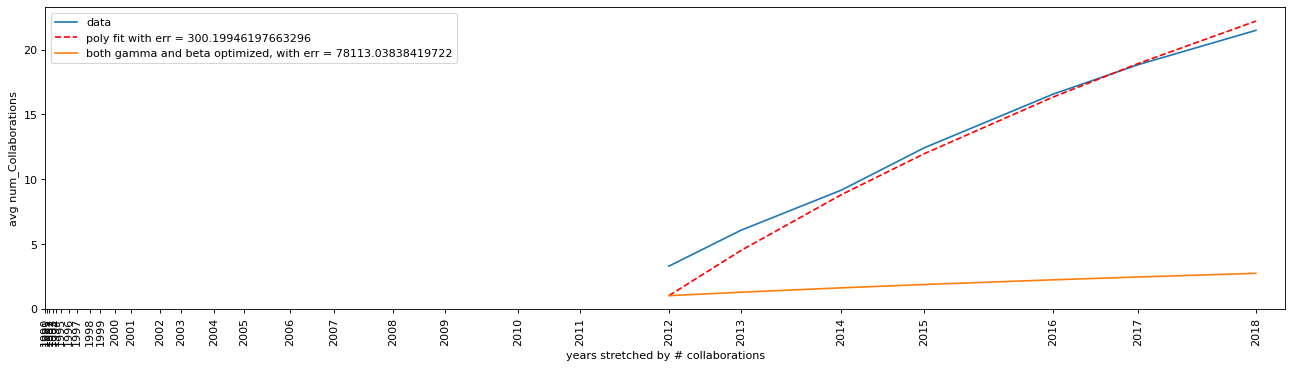

============================================================= starting year 2013 =============================================================


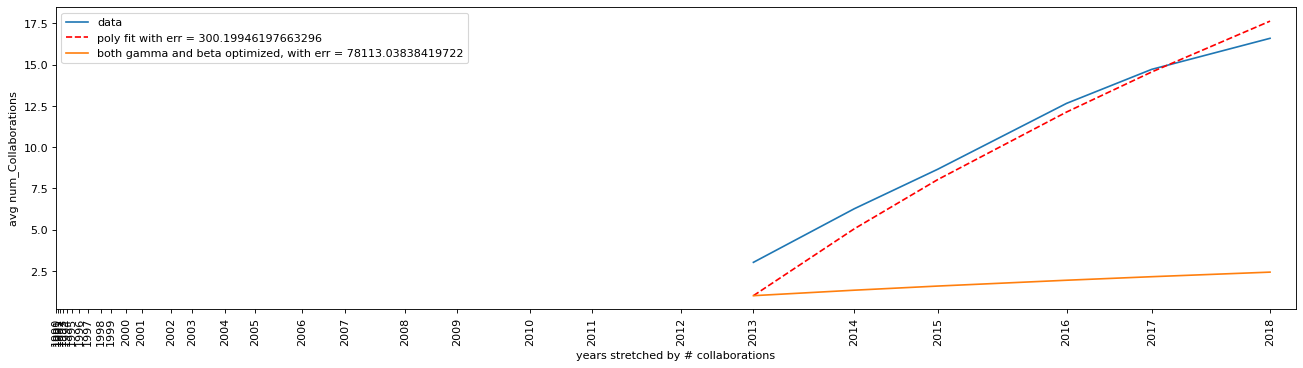

============================================================= starting year 2014 =============================================================


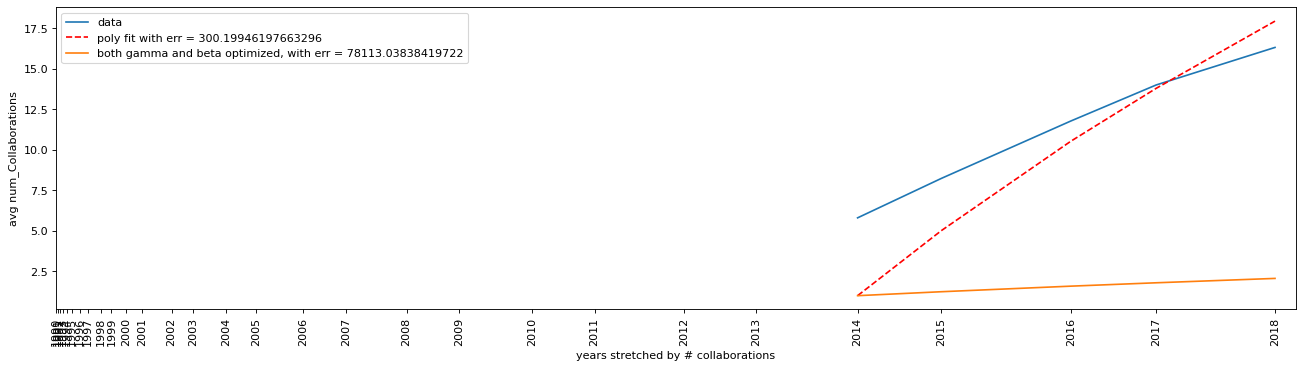

============================================================= starting year 2015 =============================================================


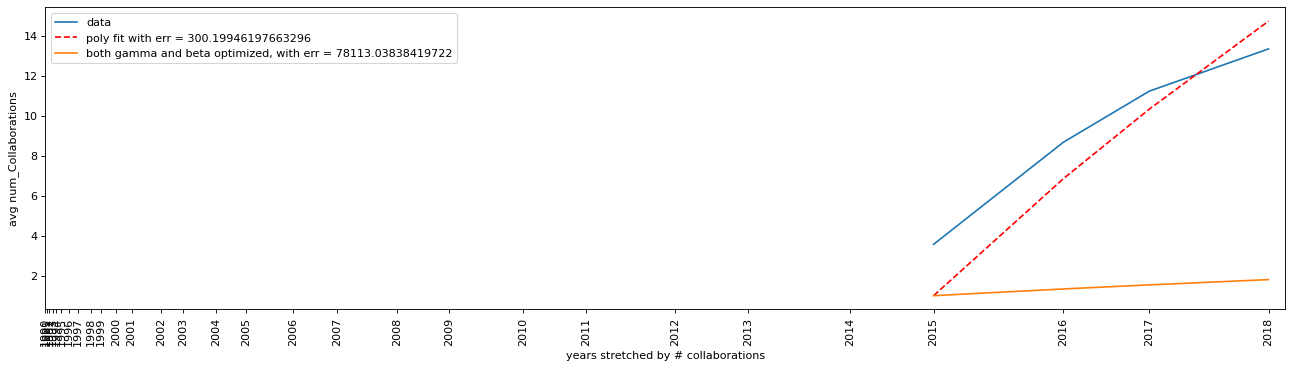

============================================================= starting year 2016 =============================================================


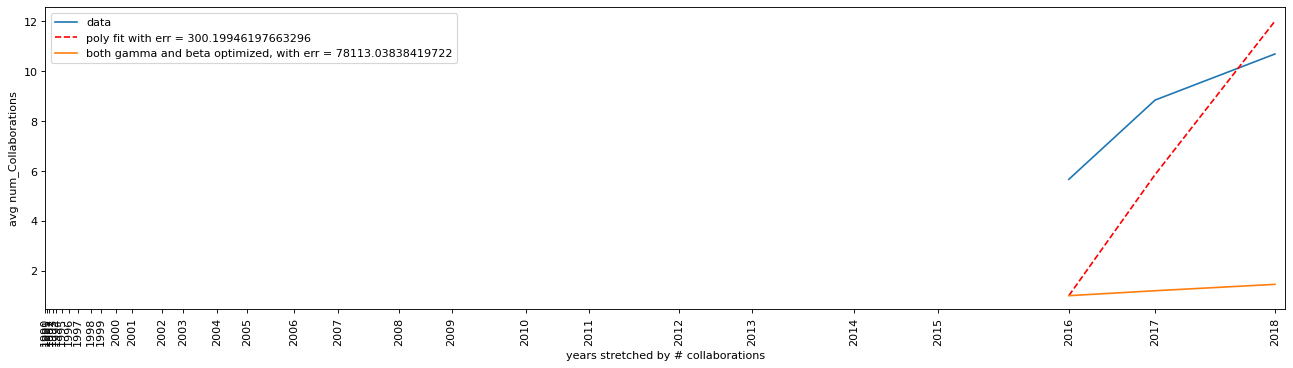

============================================================= starting year 2017 =============================================================


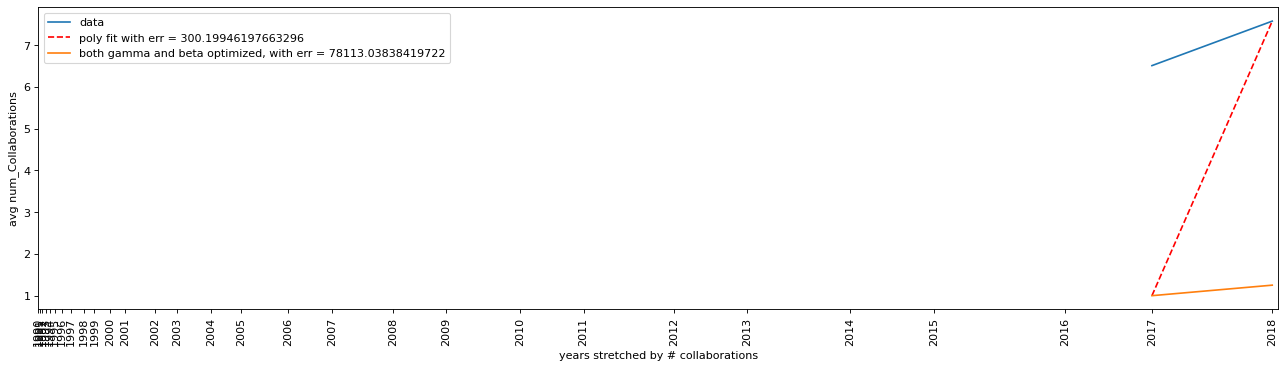

In [7]:
gammas  = []
betas = []

def func(t, gamma, beta):
    return (1 + gamma) * pow(t, beta) - gamma

def plot_f_fit(xdata, ydata, curr_x):
    popt, pcov = curve_fit(func, [x/curr_x for x in xdata], ydata, maxfev=5000)
    gammas.append(popt[0])
    betas.append(popt[1])
    print("gamma", popt[0], ", beta", popt[1])
    return func([x/curr_x for x in xdata], *popt)

# Plot fitting function of average trajectories for each starting year and hole lenght stretched by new collaborations
for size in range(min_size, max_size+1):
    gammas  = []
    betas = []
    x_y_fit = {}
    
    print((' \033[1m' + "HOLE SIZE "+str(size) + '\033[0m ').center(150, '='))
    path = 'myDATA/10-splitted_by_year/'+str(size)+'_hole_size_splitted'
    if(os.path.exists(path)):
        for y in YEARS:
            file=path+'/'+y+'_collabs_by_starting_year.csv'
            if(os.path.exists(file) and y!="2018"):
                df_y = pd.read_csv(file)
                if(len(df_y)>0):
                    png_path = "myDATA/10-splitted_by_year/"+str(size)+"_hole_size_splitted/trajectories_avg_plt/"+"_holeSize_"+str(size)+"by_num_collaborations_poly_fittings_all"+".png"

                    curr_x = get_tot_collabs_num()[YEARS.index(y)]
                    x_axis, y_axis = get_f_by_colls(df_y)  
                    print(y, end=" -> ")
                    fit_y = plot_f_fit(x_axis, y_axis, curr_x)
                    
                    x_y_fit[y] = {"x":x_axis, "y":y_axis, "fit_y":fit_y }
    
    plt.figure(figsize=(20, 8), dpi=80)

    for y in YEARS[:-1]:
        plt.plot(x_y_fit[y]["x"], x_y_fit[y]["y"])
        plt.plot(x_y_fit[y]["x"], x_y_fit[y]["fit_y"], 'r--') 
        
    plt.xlabel("years stretched by # collaborations")
    plt.ylabel("avg num_Collaborations")
    plt.xticks(rotation='vertical')
    plt.xticks(get_tot_collabs_num(), YEARS)

    plt.savefig(png_path)
    plt.show()
    
    
    print("total error for all fitted curves", tot_err_polyfit(x_y_fit))
    
    initial_guess = [1, 1]
    result = optimize.minimize(f, initial_guess)
    fitted_params = result.x
    
    ## both optimized values 
    gamma = fitted_params[0]
    beta = fitted_params[1]
    print(gamma, beta)
    ## fixing gamma to the mean 
    # gamma_mean = np.mean(gammas) # mean
    # beta1 = 1.5135571015789293 # for hole size 1

    ## fixing beta to the mean 
    # beta_mean = np.mean(betas) # mean 
    # gamma1 = 0.138066456038629  # for hole size 1

    for y in YEARS[:-1]:
        print((' \033[1m' + "starting year "+str(y) + '\033[0m ').center(150, '='))
        plt.figure(figsize=(20, 5), dpi=80)

        plt.plot(x_y_fit[y]["x"], x_y_fit[y]["y"], label="data")
        plt.plot(x_y_fit[y]["x"], x_y_fit[y]["fit_y"], 'r--', label="poly fit with err = "+tot_err_polyfit(x_y_fit))
        plt.plot(x_y_fit[y]["x"], best_g(x_y_fit[y]["x"], gamma, beta), label="both gamma and beta optimized, with err = "+tot_err(gamma, beta))
        #plt.plot(x_y_fit[y]["x"], best_g(x_y_fit[y]["x"], gamma_mean, beta1), label="gamma fixed to mean and beta optimized , with total err = "+tot_err(gamma_mean, beta1))
        #plt.plot(x_y_fit[y]["x"], best_g(x_y_fit[y]["x"], gamma1, beta_mean), label="beta fixed to mean and gamma optimized , with total err = "+tot_err(gamma1, beta_mean))

        plt.xlabel("years stretched by # collaborations")
        plt.ylabel("avg num_Collaborations")
        plt.xticks(rotation='vertical')
        plt.xticks(get_tot_collabs_num(), YEARS)
        plt.legend()
        
        fig_path = "myDATA/10-splitted_by_year/"+str(size)+"_hole_size_splitted/trajectories_avg_plt/" + str(y) + "_by_num_collaborations_gamma_beta_poly_fitting_generalized.png"
        plt.savefig(fig_path)
        plt.show()
    break